In [1]:
# Radar signal simulator
# ECE 435/535 Winter 2020
# -------------------
# Kirk Jungles
# Date: 3/17/2020
# -------------------

'''
Method: -- this is a script..
1 - Create a pulse train from Transmitter
2 - Generate a list of targets, (Range, RCS)
3 - Generate return pulses for each of the targets into a single train
4 - Attenuate 1 to reasonable power level
5 - Add 3+4
6 - Add AGWN to 5
7 - Apply detection method
'''

from matplotlib import pyplot as plt
import numpy as np
import scipy.signal as sig

# Custom libraries
import pulsetrain as pt
import pulsenoise as pn
import detection as det



## Student Custom Library 

In [2]:
def myfuction(var1, var2='1942', var3='Chain Home'):
    print(var1, var2, var3)
    x = 42
    return x, var1

#Probability of true/false return
def probDetect(num_pulses, P_max, NF):
    P_false = np.exp(-(P_max/NF)*np.sqrt(num_pulses))
    P_true = 1-P_false
    return P_true, P_false

#Very rough noise floor detector
def findNoise(signal):
    mean_signal = np.mean(signal)
    max_signal = np.max(signal)
    for k in range(0, len(signal)):
        if signal[k] >= (max_signal - mean_signal)/10:
            signal[k] = mean_signal
    noise_floor = np.mean(signal)
    return noise_floor

#Noise Adders
def addPositiveNoise(p_train, BW, NF=1):
    # add the noise in.
    kB = 1e-23
    T = 291
    #BW = 1/PW
    NoisePWR = kB*T*BW*NF
    noise = noiser_like(p_train, pwr = NoisePWR)
    signal_noise = noise + p_train
    return signal_noise

def noiser_like(signal, pwr):
    '''
    creates a noise vector like signal at a particular power level
    '''
    noisepower=pwr
    noise=noisepower*(np.random.uniform(0,1,size=len(signal)))
    return noise

#Threshold Finding function
def threshFind(Po, P_false, num_pulses):
    P = -Po/np.sqrt(num_pulses)*np.log(P_false)
    return P

#Thresholding peak finding function. Doesn't work as planned. Don't understand why. 
#No more time to debug, have other finals to do :(
def peak_finder(signal, height):
    pks = []
    vals = []
    k = 0
    while k < len(signal):
        if k == 0:
            if signal[k]>signal[k+1] and signal[k]>=height:
                pks.append(k)
                vals.append(signal[k])
                k = k + 20 #advance 0.1 km
        elif k <= (len(signal)-1):
            if signal[k]>signal[k-1] and signal[k]>signal[k+1] and signal[k]>=height:
                pks.append(k)
                vals.append(signal[k])
                k = k + 20 #advance 0.1 km
        elif k == (len(signal)-1) and signal[k]>signal[k-1] and signal[k]>=height:
                pks.append(k)
                vals.append(signal[k])
        k = k +1        
        
    return pks, vals

# usage
x, falserino = probDetect(5, 1.03, 1)
print("False = " + str(falserino)) #Testing against Midterm parameters and results. Is correct.


False = 0.09994352357086857


### Setup the RADAR parameters

In [3]:
Pavg = 100e3        # Basic Power level output of the radar
Gt = 15             # Scalar Gain of TX antenna
Gr = Gt             # Scalar Gain of RX antenna  if Gr == Gt same antenna
fc = 40e6           # Carrier Frequency, Center Frequency
vp = 3e8            # Phase Velocity of the EM wave
NF = 1              # Receiver Noise Figure
T  = 1/fc           # period of one Carrier Frequency
#derived values
Lambda = vp/fc

# Setup Time portion
PRF = 500           # Pulses per second (hertz)
PRI = 1/PRF         # Pulse Repetition Interval (seconds)
R_unamb = PRI *vp/2 # Unambiguous Range

#Num cycles per pulse packet
k = 100             # k cycles of fc in the pulse packet
PW = k*T            # k cycles * Period of fc
BW = 1/PW           # Bandwidth of the RADAR Pulse
# error check
if PW >= PRI:
    print('Error: Pulse width much too long -- PRI: {}, PW = {}'.format(PRI, PW))


### Find R-max, R-umabigous

In [4]:
# calculate maximum range with SNR = 1, n Observations = 1
SNRmin = 1
RCS = 1
Rmax = pt.calcRmax(Pavg,Gt,Gr,Lambda, BW, SNRmin = SNRmin, RCS = RCS) #, RCS, T, NF = 1,L=1, SNRmin=1)
print('Rmax(SNR:{}, RCS:{}) \t= {:.02f} km'.format(SNRmin, RCS, Rmax/1e3))
print('R unambiguous \t\t= {:.02f}km'.format(R_unamb/1e3))


Rmax(SNR:1, RCS:1) 	= 141.16 km
R unambiguous 		= 300.00km


# Setup the testing enviroment

In [5]:
num_targets = 10

target_ranges = np.random.randint(Rmax//4,Rmax,num_targets)
target_rcs = np.random.randint(1,1000,num_targets)


#### Time series Constraints

In [6]:
K_pulses = 20 # how many PRI's get simulated
dt_k = 20 # how many samples per fc period (Tc)

#### Build the sample Pulse Train and examine

In [7]:
# Make a signal smaller in amplitude to simulate the 
# blanking / attenuation in normal RADAR systems


attenuate = True
if attenuate == True:
    dBm = -100 #dBm
    scalar = 1e-3 * np.power(10,(dBm/10))
else:
    scalar = Pavg
    
main_train, PW, dt, len_PRI = pt.createPulseTrain(A=scalar,fc = fc, k=k, PRI=PRI, dt_k=dt_k, K_pulses = K_pulses)



=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Amplitude -100.00 dBm, fc:40000000.0, k:100, PRI:0.002, dt_k:20, K_pulses:20 


### Create the target reflections

In [8]:
# Now we create the returns...
main_trace = np.zeros_like(main_train) # return without TX

for idx, target_range in enumerate(target_ranges):

    pwr, dbm = pt.RadarEquationAdv(Pavg, Gt, target_range, RCS, Gr, Lambda, dB=False)
    print(':: idx: {} Power at RX {} dBm @ range: {} rmax {}'.format(idx,(10*np.log10(Pavg/1e-3)),
                                                                     target_range, R_unamb ))
    p_train, PW, dt, len_PRI = pt.createPulseTrain(A=pwr,fc = fc, k=k, PRI=PRI,
                                                   dt_k=dt_k, K_pulses = np.int(K_pulses))
    # time shift to correct spot
    p_train = pt.timeShift(p_train, target_range,vp, dt, len_PRI)
    main_trace = main_trace + p_train

:: idx: 0 Power at RX 80.0 dBm @ range: 88139 rmax 300000.0
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Amplitude -109.76 dBm, fc:40000000.0, k:100, PRI:0.002, dt_k:20, K_pulses:20 
470074
:: idx: 1 Power at RX 80.0 dBm @ range: 139493 rmax 300000.0
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Amplitude -117.74 dBm, fc:40000000.0, k:100, PRI:0.002, dt_k:20, K_pulses:20 
743962
:: idx: 2 Power at RX 80.0 dBm @ range: 42940 rmax 300000.0
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Amplitude -97.27 dBm, fc:40000000.0, k:100, PRI:0.002, dt_k:20, K_pulses:20 
229013
:: idx: 3 Power at RX 80.0 dBm @ range: 129171 rmax 300000.0
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Amplitude -116.40 dBm, fc:40000000.0, k:100, PRI:0.002, dt_k:20, K_pulses:20 
688912
:: idx: 4 Power at RX 80.0 dBm @ range: 59036 rmax 300000.0
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=

#### Merge the Transmitter Pulse train (main_train) with the reflected signals (main_trace)

#### add AWGN to the total Pulse train with returns

In [9]:
# -------------------------------
# now we add the two systems together.
# Add noise to the pulse traing
main_trace = main_trace + main_train

main_trace = pn.addNoiseToPulseTrain(main_trace,1/PW)


## DETECTION method

In [10]:
# -------------------------------
# Detection Section
# Envelope detect the signals
main_trace_env = det.envelope(main_trace)

# -------------------------------
# Gate the signal & sum them up for 
# provide n observation effects
n_obs_main_trace_env = main_trace_env.reshape(K_pulses+1, len_PRI)
# add them all together
n_obs_main_trace_env = n_obs_main_trace_env.sum(axis=0)


#### Threshold the data

[0.00000000e+00 1.87500117e-01 3.75000234e-01 ... 2.99999625e+05
 2.99999812e+05 3.00000000e+05]


Text(0, 0.5, 'Power in Watts')

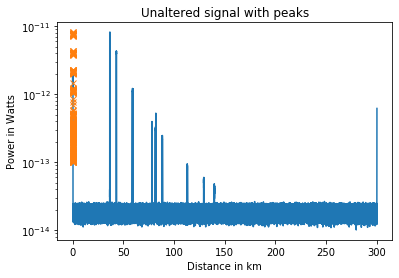

In [11]:


dBm = -100 #dBm
scalar = 1e-3 * np.power(10,(dBm/10))
#height = scalar

peaks, _ = sig.find_peaks(n_obs_main_trace_env, height=scalar)

# make the distance vector
nsamps = len(n_obs_main_trace_env)
x = np.linspace(0,R_unamb, nsamps)
dx = int(R_unamb/(len(n_obs_main_trace_env)))
print(x)

plt.semilogy(x/1e3,n_obs_main_trace_env)
plt.semilogy(peaks*dx/1e3,n_obs_main_trace_env[peaks], 'x')
plt.title('Unaltered signal with peaks')
plt.xlabel('Distance in km')
plt.ylabel('Power in Watts')

In [12]:
#Create noisier signal, test noise floor finder, then plot
noisier_signal = addPositiveNoise(n_obs_main_trace_env,1/PW, NF=10)

#function takes time, give buffer
number = 10*np.exp(10*23)

Noise floor for unaltered signal = 2.0012094379366753e-14
Noise floor for noise added signal = 2.58317217935665e-14
SNR for unaltered signal = 40.12402403019568
SNR for noise added signal = 31.067688179484524
1600000
1600000


Text(0, 0.5, 'Power in Watts')

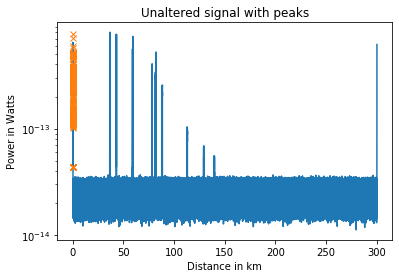

In [13]:
#Noise finder
NF_normal = findNoise(n_obs_main_trace_env)
NF_noisy = findNoise(noisier_signal)
print("Noise floor for unaltered signal = " + str(NF_normal))
print("Noise floor for noise added signal = " +str(NF_noisy))

Max_normal = max(n_obs_main_trace_env)
Max_noisy = max(noisier_signal)

SNR_normal = Max_normal/NF_normal
SNR_noisy = Max_noisy/NF_noisy
print("SNR for unaltered signal = " + str(SNR_normal))
print("SNR for noise added signal = " +str(SNR_noisy))

print(len(noisier_signal))
print(len(n_obs_main_trace_env))

plt.semilogy(x/1e3,noisier_signal)
plt.semilogy(peaks*dx/1e3,noisier_signal[peaks], 'x')
plt.title('Unaltered signal with peaks')
plt.xlabel('Distance in km')
plt.ylabel('Power in Watts')

[   2000    2005    2007 ... 1599976 1599978 1599980]
Returned pulse needs to have 6.650036819849009e-14 Watt power to be considered.


Text(0, 0.5, 'Power in dBm')

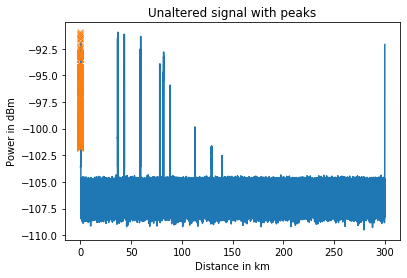

In [16]:


#Use probDetect() to determine threshold
#Want Threshold NF such that P_false = 0.00001
Thresh_false = 0.00001
NF_thresh = NF_noisy
Threshold_val = threshFind(NF_thresh, Thresh_false, K_pulses)
new_peaks, _ = sig.find_peaks(noisier_signal, Threshold_val) #This function takes time :(

print(new_peaks)
    

print("Returned pulse needs to have {} Watt power to be considered.".format(Threshold_val))

#Converted to dBm
plt.plot(x/1e3,10*np.log10(noisier_signal/0.001))
plt.plot(new_peaks*dx/1e3,10*np.log10(noisier_signal[new_peaks]/0.001), 'x')
plt.title('Unaltered signal with peaks')
plt.xlabel('Distance in km')
plt.ylabel('Power in dBm')

# HW:
This homework is for getting familiar with interacting with data. You are going to write a few functions. The functions that you are writing are relively simple. The basic simulator is supplied. I suggest you exercise it change a few functions. You have two method of adding funtions. You can either add them near the top in the #Custom Fuction# block or in the <i><b>LastName.py</b></i> file 


## Jupyter Modifications 
1. Add probablity of detection function. See "prob_detect()"
1. Add fuction to detect/generate new noise floor after gating and summing. See "findNoise()" and "addPositiveNoise()"
1. Use probability of detection function to determine threshold. Ok.
1. What is last peak? The initially sent signal
1. Convert plot to dBm. 
1. Replace find_peaks with a thresholding function

## Functions to add
1. Probablity of False Positive 
1. Find noise floor from data
1. SNR Threshold function
1. Report number of targets and distance

1.8634287928089895e-14
2.4458338396499954e-14
